# Perform inference with trained yolo model

## Imports

In [1]:
import os

import pyrootutils

root = pyrootutils.setup_root(
    search_from=os.path.dirname(os.getcwd()),
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True,
)

if os.getenv("DATA_ROOT") is None:
    os.environ["DATA_ROOT"] = f"{root}"

In [2]:
from pathlib import Path
import cv2
import hydra
from hydra import compose, initialize
import supervision as sv
import numpy as np



In [3]:
import torch

# Setup device-agnostic code
if torch.cuda.is_available():
    DEVICE = "cuda"  # NVIDIA GPU
    print("GPU Found!!")
else:
    raise Exception("No GPU Found!!")

GPU Found!!


In [4]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

## Paths setup

In [5]:
from omegaconf import DictConfig
import hydra
with initialize(config_path="../configs", job_name="EDA", version_base=None):
    cfg: DictConfig = compose(config_name="inference.yaml")
    # print(OmegaConf.to_yaml(cfg))
    print(cfg.paths)

{'root_dir': '${oc.env:PROJECT_ROOT}', 'root_data_dir': '${oc.env:DATA_ROOT}', 'results_dir': '${paths.root_dir}/results', 'log_dir': '${paths.root_dir}/logs/', 'output_dir': '${hydra:runtime.output_dir}', 'work_dir': '${hydra:runtime.cwd}', 'pretrained_model_dir': '${paths.root_dir}/pretrained_models', 'train_bst_model': '${paths.root_dir}/results/final_yolov11l_weights/best.pt', 'train_lst_model': '${paths.root_dir}/results/final_yolov11l_weights/last.pt'}


In [6]:
# auto reload libs
%load_ext autoreload
%autoreload 2

In [7]:
ROOT_DIR = Path(cfg.paths.root_dir)
ROOT_DATA_DIR = Path(cfg.paths.root_data_dir)
DATA_DIR = ROOT_DATA_DIR / cfg.datasets.datasets_dir
DATASET  = cfg.datasets.roboflow
DATA_DIR.mkdir(parents=True, exist_ok=True)
DATASET_DIR = DATA_DIR/ cfg.datasets.dataset_name
CLASS_NAMES = cfg.datasets.names
imgsz =  hydra.utils.instantiate(cfg.args.imgsz, _convert_="object")

In [8]:
TRAIN_BST_MODEL = cfg.paths.train_bst_model
TRAIN_LST_MODEL = cfg.paths.train_lst_model

## Download Datasets

In [9]:
# !wget -O "121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

In [10]:
if len(list(DATA_DIR.iterdir())) == 0:
    from roboflow import Roboflow

    rf = Roboflow()
    project = rf.workspace(DATASET.workspace).project(DATASET.project)
    version = project.version(DATASET.version)
    dataset = version.download(model_format=DATASET.model)

## YOLO model import

In [11]:
from ultralytics import YOLO
model = YOLO(TRAIN_BST_MODEL)

## Inference on Video

In [12]:
TEST_VIDEO = '/workspaces/football-players-tracking-yolo/data/0bfacc_0.mp4'

In [13]:
%matplotlib inline

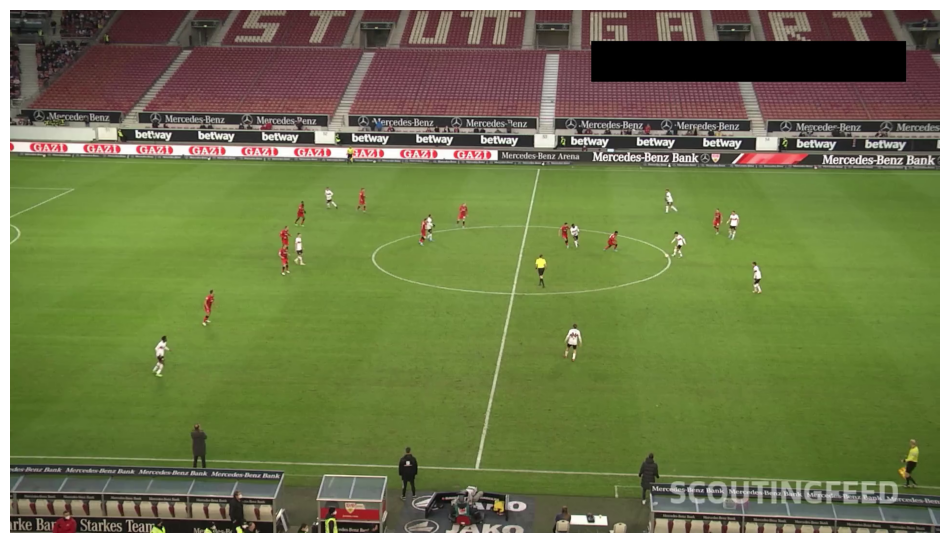

In [14]:
frame_generator = sv.get_video_frames_generator(TEST_VIDEO)
frame = next(frame_generator)
sv.plot_image(frame)

In [15]:
BALL_ID = 0
colors_list = [sv.Color.RED, sv.Color.WHITE, sv.Color.GREEN, sv.Color.BLUE]
colors = sv.ColorPalette(colors= colors_list)

# ellip_annotator = sv.EllipseAnnotator(color=colors,thickness=2)
ellip_annotator = sv.EllipseAnnotator(color=colors,thickness=2)
traingle_annot = sv.TriangleAnnotator(color=colors_list[0], 
                                          base=25,
    height=21,
    outline_thickness=1)
label_annotator = sv.LabelAnnotator(
    color=colors,
    text_color=sv.Color.BLACK,
    text_position=sv.Position.TOP_CENTER
)

In [16]:
# def _callback(image_slice: np.ndarray) -> sv.Detections:
#     # result = model(image_slice)[0]
#     result = model.predict(image_slice, conf=0.3)[0]
#     # result = model.predict(image_slice, imgsz=imgsz, conf=0.3)[0]
#     detections = sv.Detections.from_ultralytics(result)
#     return detections

# slicer = sv.InferenceSlicer(callback =_callback,
#                             # slice_wh=(512, 512),
#                             # overlap_wh=None, 
#                             # thread_workers=8
#                             )

# detections = slicer(frame)
# result = model.predict(frame, conf=0.3)[0]
result = model.predict(frame, imgsz=imgsz, conf=0.3)[0]
detections = sv.Detections.from_ultralytics(result)
detections


0: 736x1280 21 players, 3 referees, 56.8ms
Speed: 10.5ms preprocess, 56.8ms inference, 123.4ms postprocess per image at shape (1, 3, 736, 1280)


Detections(xyxy=array([[     1142.3,      644.56,        1181,      726.63],
       [     1084.2,       501.4,      1108.3,      574.68],
       [     1835.6,      883.71,      1876.7,      987.15],
       [     293.44,      671.75,      332.15,      757.43],
       [      715.5,      367.34,       735.9,      418.62],
       [     1478.7,      412.83,      1505.7,      475.67],
       [     1531.6,      518.13,      1552.6,      586.56],
       [     397.67,      575.85,      421.44,      653.24],
       [     649.84,      364.02,      676.22,      413.67],
       [     1351.5,      368.12,      1378.7,      420.87],
       [     921.48,      397.32,      945.05,      451.76],
       [     1364.3,      454.61,      1396.3,      511.91],
       [     586.16,      458.92,      609.46,      528.73],
       [     586.94,      392.88,      611.24,      448.65],
       [       1450,      408.53,      1470.7,      465.14],
       [     1225.8,      455.17,      1255.5,      500.11],
       [

In [17]:
ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

rest_detections = detections[detections.class_id != BALL_ID]
rest_detections= rest_detections.with_nms(threshold=0.5, class_agnostic=True)
rest_detections.class_id -=1

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]
frame = frame.copy()
annot_frame = ellip_annotator.annotate(scene=frame, detections=rest_detections)

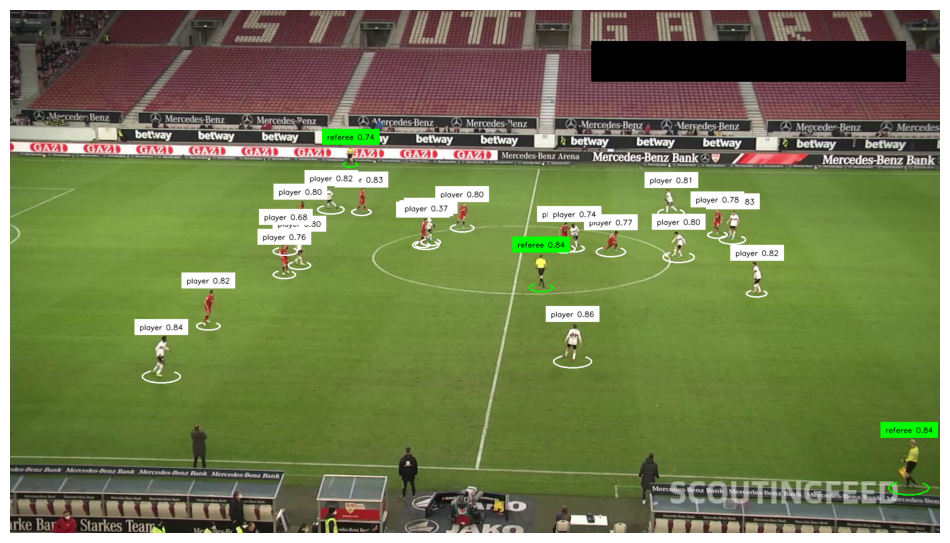

In [18]:
annot_frame = traingle_annot.annotate(scene=annot_frame, detections=ball_detections)
annotated_frame = label_annotator.annotate(
    scene=annot_frame,
    detections=rest_detections,
    labels=labels)
sv.plot_image(annot_frame)

In [19]:
def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # https://hydra.cc/docs/advanced/instantiate_objects/overview/#parameter-conversion-strategies
    
    result = model.predict(frame, imgsz=imgsz, conf=0.3)[0]
    detections = sv.Detections.from_ultralytics(result)
    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    rest_detections = detections[detections.class_id != BALL_ID]
    rest_detections= rest_detections.with_nms(threshold=0.5, class_agnostic=True)
    rest_detections.class_id -=1

    labels = [
        f"{class_name} {confidence:.2f}"
        for class_name, confidence
        in zip(rest_detections['class_name'], detections.confidence)
    ]
    annot_frame = ellip_annotator.annotate(scene=frame.copy(), detections=rest_detections)
    annot_frame = label_annotator.annotate(scene=annot_frame,detections=rest_detections,labels=labels)
    annot_frame = traingle_annot.annotate(scene=annot_frame, detections=ball_detections)
    return annot_frame

sv.process_video(
    source_path=TEST_VIDEO,
    target_path="/workspaces/football-players-tracking-yolo/results/result.mp4",
    callback=callback
)


0: 736x1280 21 players, 3 referees, 21.1ms
Speed: 7.7ms preprocess, 21.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 3 referees, 21.1ms
Speed: 5.2ms preprocess, 21.1ms inference, 0.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 3 referees, 21.1ms
Speed: 4.1ms preprocess, 21.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 22 players, 3 referees, 20.9ms
Speed: 3.2ms preprocess, 20.9ms inference, 0.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 23 players, 3 referees, 20.4ms
Speed: 3.1ms preprocess, 20.4ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 3 referees, 20.1ms
Speed: 3.2ms preprocess, 20.1ms inference, 0.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 19 players, 3 referees, 19.7ms
Speed: 3.2ms preprocess, 19.7ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 73

## Detecting Players in 2 teams and annoting them in 2 colors

In [37]:
from tqdm import tqdm
PLAYER_ID = 2
STRIDE = 20
frame_generator = sv.get_video_frames_generator(TEST_VIDEO, stride=STRIDE)

In [38]:
players_crop = []
for frame in tqdm(frame_generator, desc="Collecting players crop"):
    result = model.predict(frame, imgsz=imgsz, conf=0.3)[0]
    detections = sv.Detections.from_ultralytics(result)
    # Non-maximum suppression (NMS) is a technique used in object detection to eliminate 
    # redundant bounding boxes for the same object, ensuring that each object is represented by a single, precise bounding box. 
    player_detections = detections.with_nms(threshold=0.5, class_agnostic=True)
    player_detections = detections[detections.class_id == PLAYER_ID]
    players_crop += [sv.crop_image(frame, xyxy) for xyxy in player_detections.xyxy]


0: 736x1280 21 players, 3 referees, 20.4ms
Speed: 18.5ms preprocess, 20.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 1 ball, 20 players, 3 referees, 19.7ms
Speed: 8.4ms preprocess, 19.7ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 20 players, 3 referees, 21.1ms
Speed: 6.9ms preprocess, 21.1ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 22 players, 3 referees, 20.8ms
Speed: 7.5ms preprocess, 20.8ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 20 players, 4 referees, 20.2ms
Speed: 6.9ms preprocess, 20.2ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 1 ball, 20 players, 4 referees, 18.4ms
Speed: 6.7ms preprocess, 18.4ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 3 referees, 17.3ms
Speed: 8.0ms preprocess, 17.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 3 referees, 17.2ms
Speed: 7.4ms preprocess, 17.2ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 1 ball, 21 players, 3 referees, 16.9ms
Speed: 6.7ms preprocess, 16.9ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 22 players, 3 referees, 17.2ms
Speed: 8.1ms preprocess, 17.2ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 3 referees, 18.2ms
Speed: 6.4ms preprocess, 18.2ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 21 players, 3 referees, 19.4ms
Speed: 6.3ms preprocess, 19.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 3 referees, 20.1ms
Speed: 7.7ms preprocess, 20.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 20 players, 3 referees, 19.8ms
Speed: 6.8ms preprocess, 19.8ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 21 players, 3 referees, 19.4ms
Speed: 6.5ms preprocess, 19.4ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 22 players, 3 referees, 19.4ms
Speed: 6.7ms preprocess, 19.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 22 players, 3 referees, 20.6ms
Speed: 7.4ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 21 players, 3 referees, 19.8ms
Speed: 6.1ms preprocess, 19.8ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 3 referees, 20.1ms
Speed: 6.4ms preprocess, 20.1ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 4 referees, 19.4ms
Speed: 8.0ms preprocess, 19.4ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 1 ball, 20 players, 3 referees, 19.6ms
Speed: 7.6ms preprocess, 19.6ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 20 players, 3 referees, 19.5ms
Speed: 6.2ms preprocess, 19.5ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 20 players, 3 referees, 20.1ms
Speed: 7.1ms preprocess, 20.1ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 1 ball, 22 players, 3 referees, 20.0ms
Speed: 8.2ms preprocess, 20.0ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 3 referees, 19.8ms
Speed: 7.2ms preprocess, 19.8ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 3 referees, 20.1ms
Speed: 6.9ms preprocess, 20.1ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 20 players, 2 referees, 19.5ms
Speed: 7.2ms preprocess, 19.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 3 referees, 20.1ms
Speed: 7.2ms preprocess, 20.1ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 3 referees, 19.9ms
Speed: 7.5ms preprocess, 19.9ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 21 players, 3 referees, 20.3ms
Speed: 8.5ms preprocess, 20.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 20 players, 3 referees, 19.8ms
Speed: 6.7ms preprocess, 19.8ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 19 players, 3 referees, 19.5ms
Speed: 6.8ms preprocess, 19.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 23 players, 2 referees, 20.1ms
Speed: 6.7ms preprocess, 20.1ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 23 players, 3 referees, 20.1ms
Speed: 8.0ms preprocess, 20.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 20.0ms
Speed: 6.9ms preprocess, 20.0ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 1 ball, 19 players, 3 referees, 20.6ms
Speed: 6.7ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 18 players, 3 referees, 20.1ms
Speed: 6.9ms preprocess, 20.1ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 21 players, 3 referees, 19.6ms
Speed: 6.0ms preprocess, 19.6ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


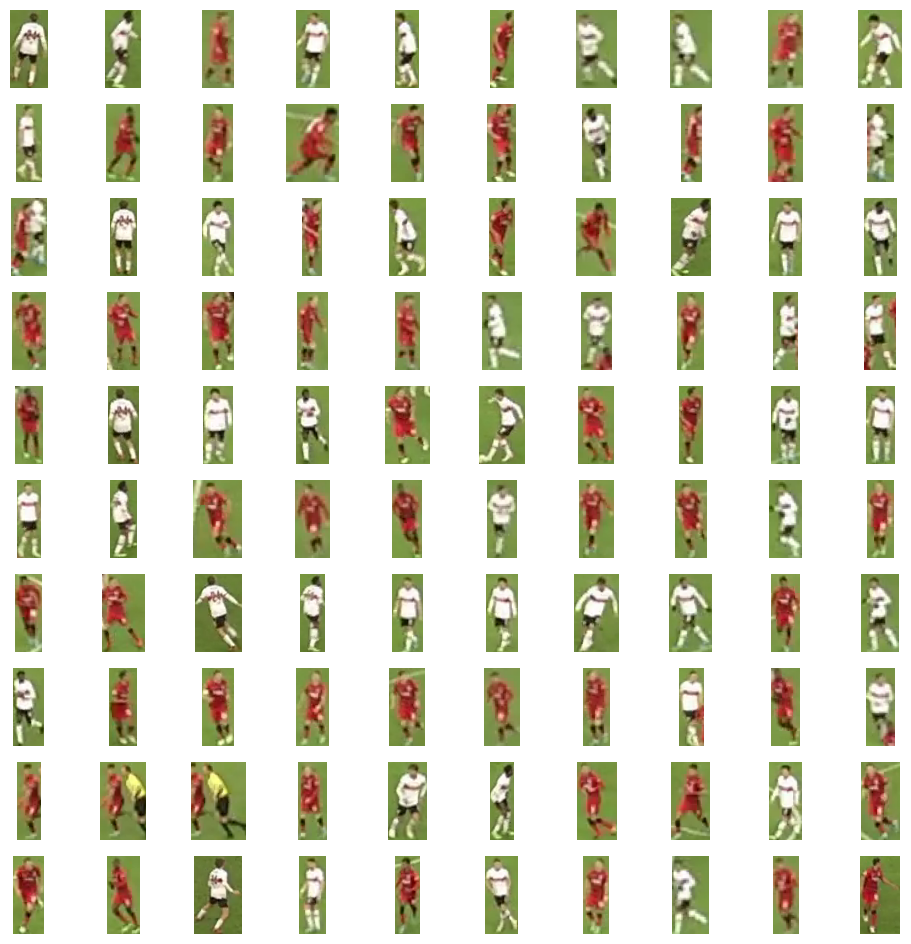

In [40]:
sv.plot_images_grid(players_crop[:100], grid_size=(10, 10))